In [ ]:
pip install pandas numpy scikit-learn matplotlib seaborn tqdm joblib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import json

In [4]:
def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    return df

df = load_dataset("C:\\Users\\eldho\\Documents\\guvi\\repos\\taxi_fare\\taxi_fare.csv")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212345 entries, 0 to 212344
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               212345 non-null  int64  
 1   tpep_pickup_datetime   212345 non-null  object 
 2   tpep_dropoff_datetime  212345 non-null  object 
 3   passenger_count        212345 non-null  int64  
 4   pickup_longitude       212345 non-null  float64
 5   pickup_latitude        212345 non-null  float64
 6   RatecodeID             212345 non-null  int64  
 7   store_and_fwd_flag     212345 non-null  object 
 8   dropoff_longitude      212345 non-null  float64
 9   dropoff_latitude       212345 non-null  float64
 10  payment_type           212345 non-null  int64  
 11  fare_amount            212345 non-null  float64
 12  extra                  212345 non-null  float64
 13  mta_tax                212345 non-null  float64
 14  tip_amount             212345 non-nu

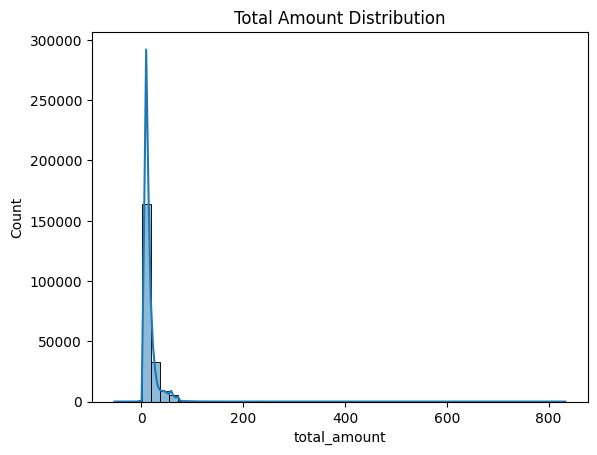

In [5]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Visualize target distribution
sns.histplot(df['total_amount'], bins=50, kde=True)
plt.title('Total Amount Distribution')
plt.show()

In [16]:
df.count()

VendorID                 212345
tpep_pickup_datetime     212345
tpep_dropoff_datetime    212345
passenger_count          212345
pickup_longitude         212345
pickup_latitude          212345
RatecodeID               212345
store_and_fwd_flag       212345
dropoff_longitude        212345
dropoff_latitude         212345
payment_type             212345
fare_amount              212345
extra                    212345
mta_tax                  212345
tip_amount               212345
tolls_amount             212345
improvement_surcharge    212345
total_amount             212345
dtype: int64

In [ ]:
from datetime import datetime

def engineer_features(df):
    # Example: Add pickup_hour, pickup_dayofweek, etc.
    df = df.copy()
    df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_am_pm'] = df['pickup_hour'].apply(lambda x: 'am' if x < 12 else 'pm')
    df['pickup_is_weekend'] = df['pickup_dayofweek'].isin([5,6]).astype(int)
    df['is_night'] = df['pickup_hour'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)
    df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
    # Haversine distance
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        phi1, phi2 = np.radians(lat1), np.radians(lat2)
        dphi = np.radians(lat2 - lat1)
        dlambda = np.radians(lon2 - lon1)
        a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
        return 2*R*np.arcsin(np.sqrt(a))
    df['trip_distance_km'] = haversine(
        df['pickup_latitude'], df['pickup_longitude'],
        df['dropoff_latitude'], df['dropoff_longitude']
    )
    return df

df_fe = engineer_features(df)
df_fe.head()

In [ ]:
def remove_outliers_iqr(data, columns, iqr_multiplier=1.5):
    cleaned = data.copy()
    mask = pd.Series(True, index=cleaned.index)
    for col in columns:
        if col in cleaned.columns:
            col_series = cleaned[col].astype(float)
            q1 = col_series.quantile(0.25)
            q3 = col_series.quantile(0.75)
            iqr = q3 - q1
            lower = q1 - iqr_multiplier * iqr
            upper = q3 + iqr_multiplier * iqr
            mask &= col_series.between(lower, upper) | col_series.isna()
    return cleaned[mask]

df_fe = df_fe[df_fe["total_amount"] > 0]
outlier_cols = ["fare_amount", "trip_distance_km", "trip_duration_min", "total_amount"]
df_fe = remove_outliers_iqr(df_fe, outlier_cols, 1.5)
df_fe.shape

In [ ]:
numeric_features = [
    "passenger_count", "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "fare_amount", "trip_distance_km", "trip_duration_min",
    "pickup_hour", "pickup_dayofweek", "VendorID", "RatecodeID"
]
categorical_features = [
    "store_and_fwd_flag", "payment_type", "pickup_am_pm", "pickup_is_weekend", "is_night"
]

numeric_features = [c for c in numeric_features if c in df_fe.columns]
categorical_features = [c for c in categorical_features if c in df_fe.columns]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("scaler", StandardScaler(with_mean=False)),
])
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

In [ ]:
feature_df = df_fe.drop(columns=["total_amount"], errors="ignore")
target = df_fe["total_amount"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    feature_df, target, test_size=0.2, random_state=42
)



In [ ]:
models = {
    "linear": LinearRegression(),
    "ridge": Ridge(),
    "lasso": Lasso(),
    "random_forest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "gbm": GradientBoostingRegressor(random_state=42),
    "svr": SVR(kernel='linear'),
    "decision_tree": DecisionTreeRegressor(random_state=42)
}

def evaluate_regression(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {"r2": r2, "mse": mse, "rmse": rmse, "mae": mae}



In [ ]:
results = {}
best_rmse = float("inf")
best_name = None
best_pipeline = None

for name, model in tqdm(models.items(), desc="Training models"):
    if name == "svr":
        X_train_svr = X_train.sample(n=min(5000, len(X_train)), random_state=42)
        y_train_svr = y_train.loc[X_train_svr.index]
        pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
        pipe.fit(X_train_svr, y_train_svr)
    else:
        pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
        pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    metrics = evaluate_regression(y_test, preds)
    results[name] = metrics
    if metrics["rmse"] < best_rmse:
        best_rmse = metrics["rmse"]
        best_name = name
        best_pipeline = pipe

print("Results:", json.dumps(results, indent=2))
print(f"Best model: {best_name} with RMSE: {best_rmse:.4f}")

In [ ]:
param_grids = {
    "random_forest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": [1, 2, 5]
    },
    "ridge": {"model__alpha": np.logspace(-3, 3, 7)},
    "lasso": {"model__alpha": np.logspace(-4, 1, 6)},
    "gbm": {
        "model__learning_rate": [0.01, 0.1],
        "model__n_estimators": [100, 200],
        "model__max_depth": [3, 4]
    }
}

if best_name in param_grids:
    search = RandomizedSearchCV(
        Pipeline([("preprocess", preprocessor), ("model", models[best_name])]),
        param_distributions=param_grids[best_name],
        n_iter=10,
        scoring="neg_root_mean_squared_error",
        cv=3,
        random_state=42,
        verbose=1,
    )
    search.fit(X_train, y_train)
    tuned_pipe = search.best_estimator_
    tuned_preds = tuned_pipe.predict(X_test)
    tuned_metrics = evaluate_regression(y_test, tuned_preds)
    print(f"Tuned {best_name} metrics:", tuned_metrics)
    best_pipeline = tuned_pipe  # Update best pipeline if improved

In [ ]:
joblib.dump(best_pipeline, "best_model.joblib")
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Model and results saved.")